In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
from skimage.measure import label, regionprops, regionprops_table
from tqdm.notebook import tqdm

In [2]:
rename_dict = {v:k for k, v in {"area": "area(mm2)", 
                                      "convex_area": "convex_area(mm2)", 
                                      "equivalent_diameter": "equivalent_diameter(mm)", 
                                      "major_axis_length": "major_axis_length(mm)",
                                      "minor_axis_length": "minor_axis_length(mm)", 
                                      "perimeter": "perimeter(mm)"}.items()}
rename_dict

{'area(mm2)': 'area',
 'convex_area(mm2)': 'convex_area',
 'equivalent_diameter(mm)': 'equivalent_diameter',
 'major_axis_length(mm)': 'major_axis_length',
 'minor_axis_length(mm)': 'minor_axis_length',
 'perimeter(mm)': 'perimeter'}

In [3]:
merged_pd = pd.read_excel("../03_data_ana/out/2020_measured_fix.xlsx")
merged_pd = merged_pd.rename(columns=rename_dict)
merged_pd

,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity,Ground_ID,UAV_ID,flower_size_max
0,20200522,2815,9040,9629,0.789613,107.285066,141.287568,86.694770,136.758377,91.151993,400.617316,0.707814,N20_30,2815,131
1,20200522,2816,12157,12694,0.632702,124.413718,142.835094,110.610777,138.253326,115.262581,440.717821,0.786530,N20_29,2816,130
2,20200522,2817,8064,9785,0.706411,101.328198,133.284799,94.339247,128.514725,97.051231,429.759451,0.548668,N20_28,2817,109
3,20200522,2818,11077,12338,0.726258,118.758892,147.070639,101.099568,141.267517,102.744728,469.303607,0.632010,N20_27,2818,143
4,20200522,2827,11978,12648,0.728131,123.494386,150.504740,103.161644,145.275421,105.871941,447.788889,0.750667,N20_18,2827,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20200528,3642,22832,23632,0.496955,170.501042,183.758068,159.460846,178.484558,166.459473,597.712770,0.803098,S25_05,3642,171
354,20200528,3643,19597,20709,0.331038,157.960993,164.168401,154.912143,160.859299,159.415680,570.150324,0.757566,S25_04,3643,162
355,20200528,3644,13382,16270,0.873109,130.531573,200.760852,97.875911,189.000305,108.115051,566.156421,0.524636,S25_03,3644,173
356,20200528,3645,20596,22777,0.675346,161.937153,194.540305,143.473633,190.830292,153.818451,614.742207,0.684868,S25_02,3645,181


In [5]:
non_destructive = pd.read_csv("../03_data_ana/out/non_destructive20.csv")
non_destructive

,date,Ground_ID,UAV_ID,flower_size_max
0,20200522,S20_01,2916,77
1,20200522,S20_02,2915,153
2,20200522,S20_03,2914,124
3,20200522,S20_04,2913,102
4,20200522,S20_05,2912,103
...,...,...,...,...
355,20200528,N25_26,3548,157
356,20200528,N25_27,3547,168
357,20200528,N25_28,3546,166
358,20200528,N25_29,3545,146


In [7]:
pd.unique(non_destructive.date)

array([20200522, 20200526, 20200528], dtype=int64)

# Draw figures

In [10]:
from matplotlib.collections import PolyCollection
import seaborn as sns
import matplotlib.patheffects as pe

In [8]:
match_date = [20200522, 20200526, 20200528]

In [57]:
USMALL_SIZE = 12 + 8
SMALL_SIZE = 16 + 8
MEDIUM_SIZE = 18 + 8
BIGGER_SIZE = 20 + 8

cm = 1/2.54

plt.rc('font', size=SMALL_SIZE, family='Times New Roman')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [22]:
palette = sns.color_palette("tab10", n_colors=3)
#palette.remove(palette[2])
#palette.remove(palette[2])
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

def lowess(x, y, frac=0.5):
    lowess = sm.nonparametric.lowess
    z = lowess(y, x, frac)
    x_points = []
    y_points = []
    for x_y in z:
        x_points.append(x_y[0])
        y_points.append(x_y[1])
    return x_points, y_points

def linear(x, y, printf=True):
    def func(x, a, b):
        y = a * x + b
        return y

    def fitans(xdata, ydata):
        popt, pcov = curve_fit(func, xdata, ydata)
        residuals = ydata - func(xdata, *popt)
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        return popt, pcov, r_squared
    
    t, p, r2 = fitans(x, y)
    
    x_points = np.linspace(min(x), max(x), num=max(int(max(x)-min(x))+1, 100), endpoint=True)
    y_points = func(x_points, *t)
    y_predict = func(x, *t)
    if printf:
        print(f'y={round(t[0], 3)}x+{round(t[1], 3)}  R^2={round(r2, 2)}')
        print(f'RMSE = {rmse(y_predict, y)}')
        print('-----------------')
    return x_points, y_points, y_predict, t, r2

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

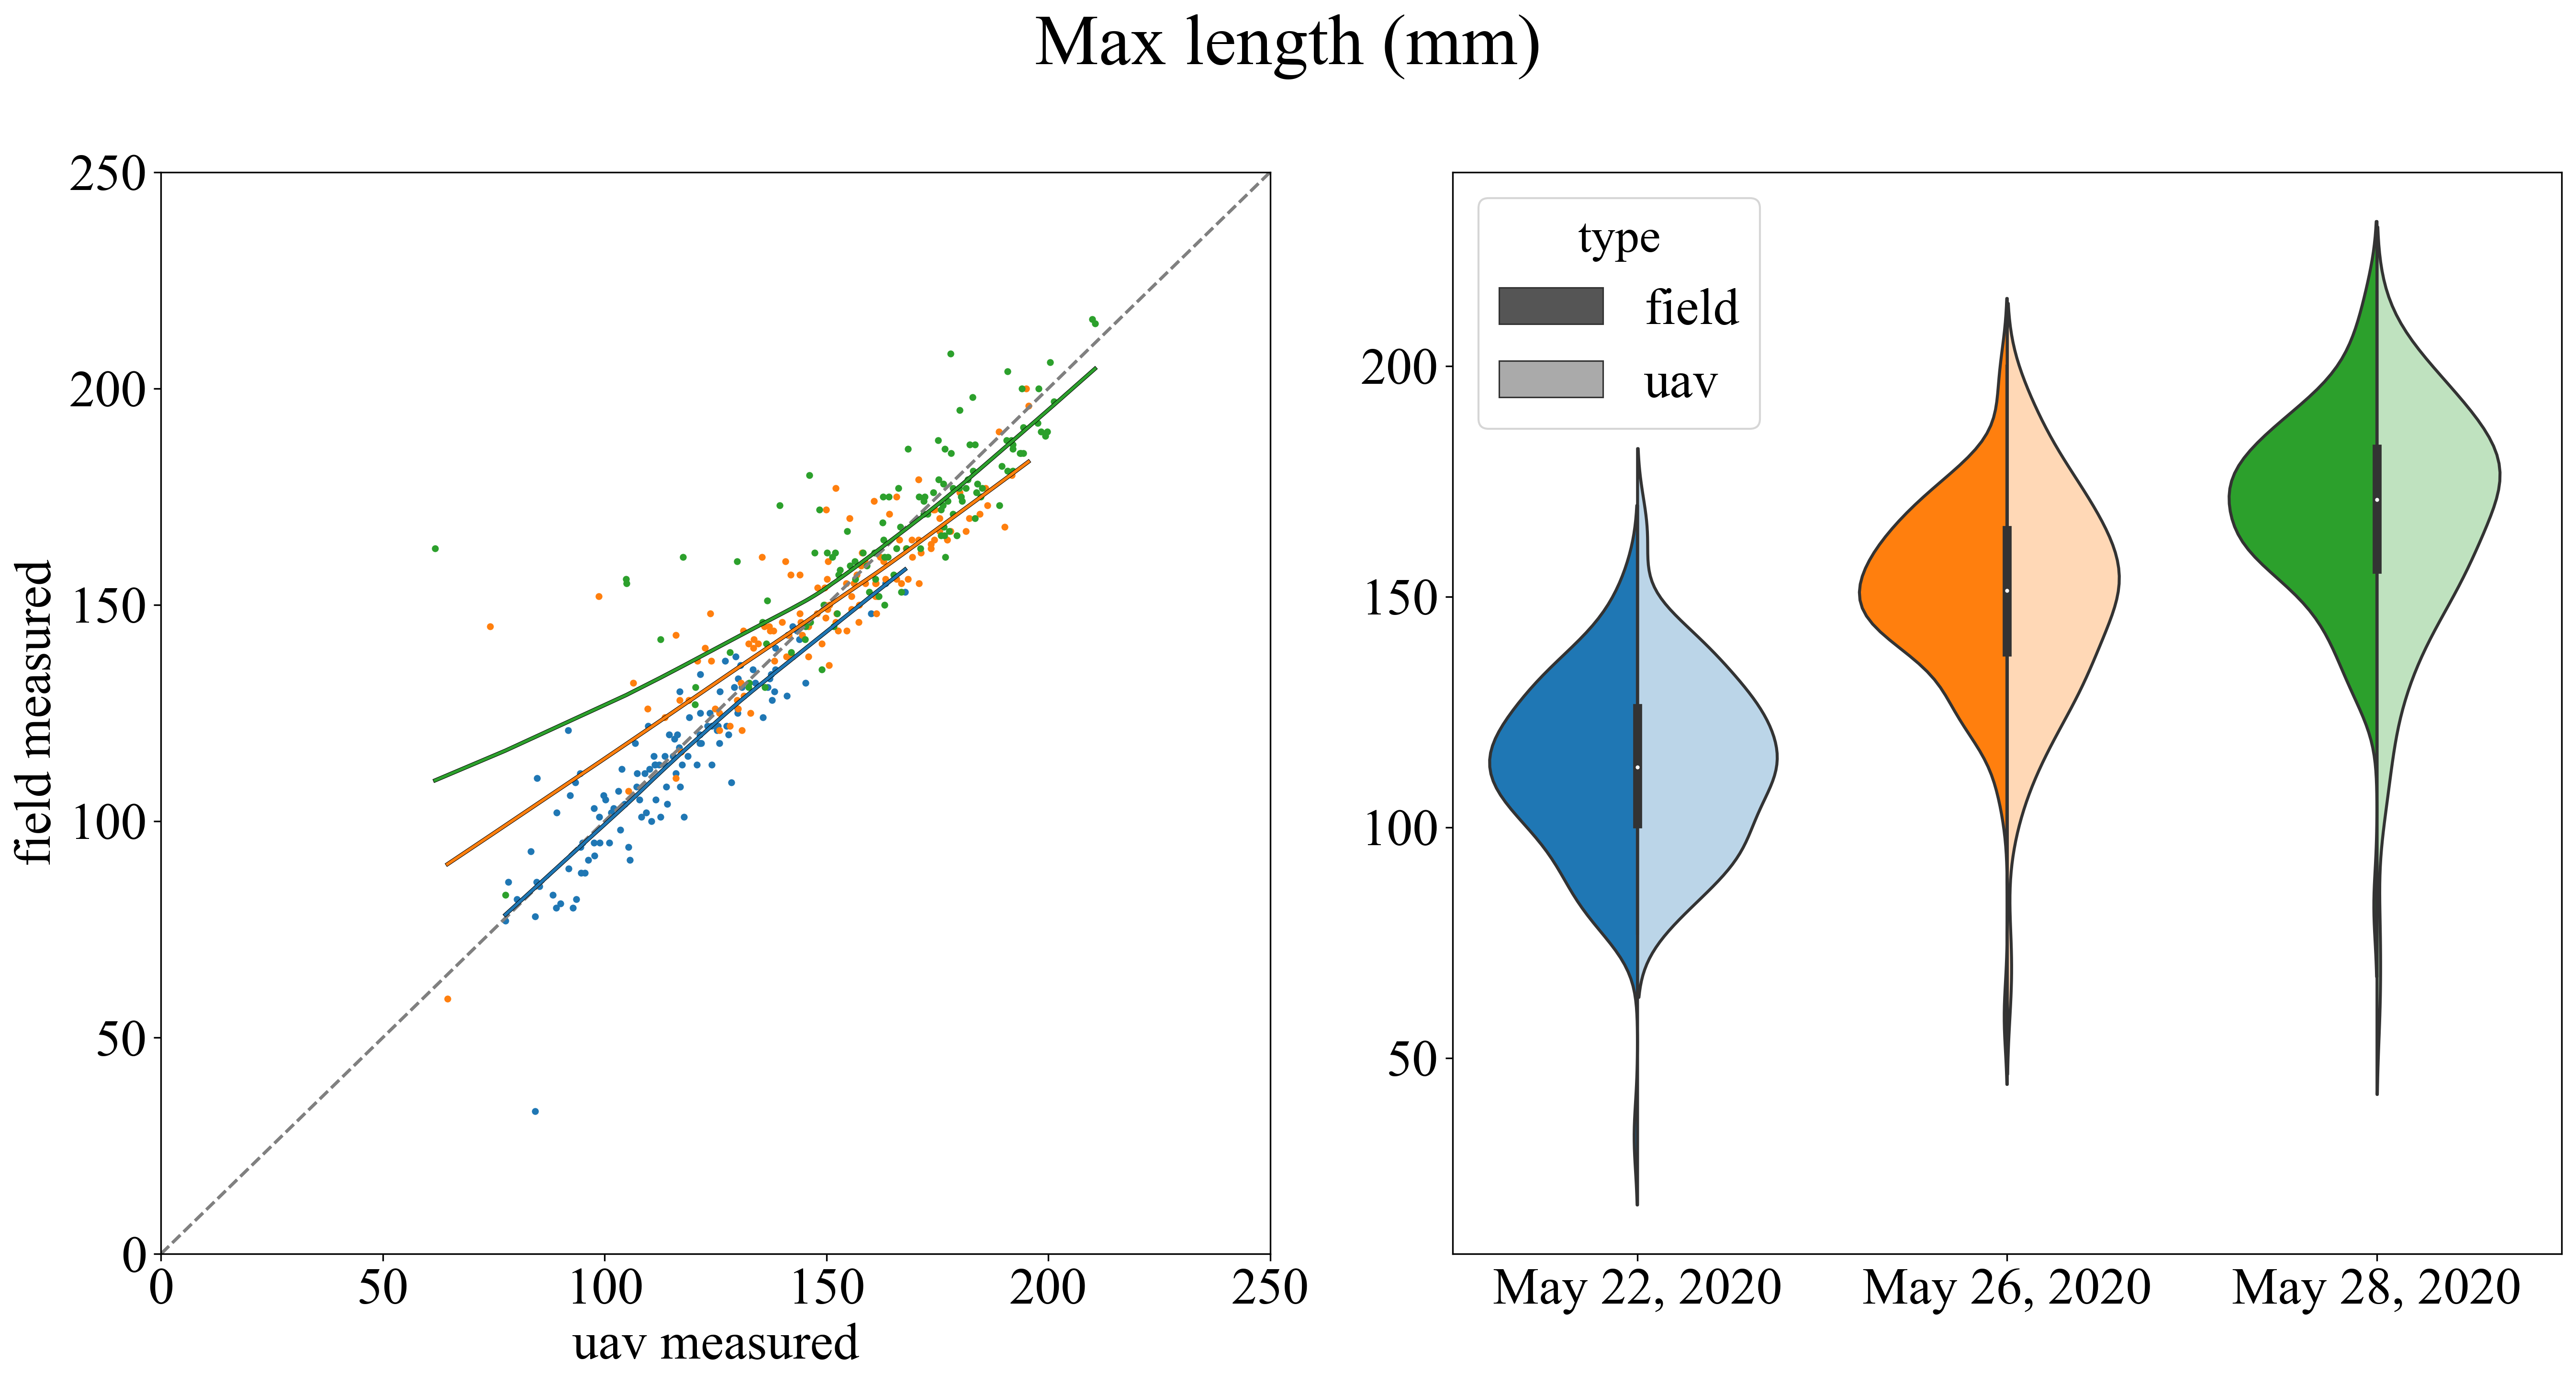

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18.46, 10), dpi=300)
    
violin_list = []
for i, d in enumerate(match_date):
    field = merged_pd[merged_pd.date == d]
    uav = merged_pd[merged_pd.date == d]
    
    ax[0].plot([0,250], [0, 250], '--', color="gray")
    ax[0].scatter(uav.min_area_rect_max, field.flower_size_max, color=palette[i], marker='o', s=6)
    
    reg_x, reg_y = lowess(uav.min_area_rect_max, field.flower_size_max, 0.9)
    ax[0].plot(reg_x, reg_y, '-', color=palette[i], zorder=20, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
    ax[0].set_xlim(0, 250)
    ax[0].set_ylim(0, 250)
    
    ax[0].set_xlabel("uav measured")
    ax[0].set_ylabel("field measured")
    
    fi = field.rename(columns={"flower_size_max": "max_length"})
    fi["type"] = "field"
    fi = fi[["date", "max_length", "type"]]
    
    
    uv = uav.rename(columns={"min_area_rect_max": "max_length"})
    uv["type"] = "uav"
    uv = uv[["date", "max_length", "type"]]
    
    data_violin = pd.concat([fi, uv])
    violin_list.append(data_violin)
    
violin_data = pd.concat(violin_list)
    
# violin plot
result_dict = sns.violinplot(x="date", y="max_length", hue="type", data=violin_data, split=True, ax=ax[1], palette="gray")

## change_color
collect = [item for item in result_dict.collections if isinstance(item, PolyCollection)]
for k, it in enumerate(collect):
    if k % 2 == 0: 
        color = list(palette[k//2]) + [1]
    else:
        color = list(palette[k//2]) + [0.3]

    it.set_facecolor(color)
    
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_xticklabels(["May 22, 2020", "May 26, 2020", "May 28, 2020"])

plt.suptitle("Max length (mm)", fontsize=36)
plt.tight_layout()

plt.savefig("2020_results.png")

plt.show()

In [38]:
violin_data

,date,max_length,type
0,20200522,131.000000,field
1,20200522,130.000000,field
2,20200522,109.000000,field
3,20200522,143.000000,field
4,20200522,132.000000,field
...,...,...,...
353,20200528,178.484558,uav
354,20200528,160.859299,uav
355,20200528,189.000305,uav
356,20200528,190.830292,uav
